# Predicting tennis match outcomes

I'm not much of a gambler, so I was fortunate on my first trip to Las Vegas last year to be traveling with a friend who really know the ropes (e.g. among other things, where to find $8 steaks at 2 in the morning). I came away from the experience, as you might expect, with less money in my bank account, but the losses were  surprisingly minimal thanks to my favorite of the various degenerate pastimes to which I was introduced: betting on tennis matches.

We were in Vegas during the clay-court leadup to the French Open, betting mainly on early-round matches in Rome; my proudest moment was picking then-seventeen-year-old Jannik Sinner's upset over Steve Johnson, but we also did well overall, both when it came to picking individual matches and in "system" betting, where out of a group of bets a certain number have to win to pay out. I don't know the exact numbers, but we came out on top in the end.

Predicting tennis upsets is something of an art. Tennis is a messy game, and while a lot of matches go in favor of the higher-ranked player (around 65\% of ATP matches, as we'll see), those remaining 35\% that are upsets come about as a result of a lot of different factors: a mismatch of game styles or surface preferences, a ranking propped up by a great result nine months ago that doesn't reflect a recent losing streak, a hot serving day by an underdog, a single net-cord shot in a tiebreaker... It's the kind of problem where a seemingly mediocre success rate might actually be state-of-the-art. 

It's also a great candidate for some data-driven exploration and modeling, because there's a lot of good data available. I was inspired to take a look at this problem when I found match statistics from the ATP tour from most of the past 20 years on [Kaggle](http://www.kaggle.com), and I've supplemented that dataset with player information from [Jeff Sackmann's amazing repository](https://github.com/JeffSackmann/tennis_atp), where you can also find the same match data and much more.

There's also some literature on the topic that provides an illuminating baseline (sorry) for the present exploration. Probably the best paper on tennis match prediction is Stephanie Kovalchik's [(2016)](https://core.ac.uk/download/pdf/86638968.pdf) overview of different approaches; there's also this [master's thesis](https://project-archive.inf.ed.ac.uk/msc/20172425/msc_proj.pdf), which provides its own helpful lit review, and [this paper](http://cs229.stanford.edu/proj2017/final-reports/5242116.pdf), which appears to be a project for a Stanford computer science course. [Kovalchik](http://on-the-t.com) and [Sackmann](http://www.tennisabstract.com/blog/) both also have excellent blogs filled with tons of discussion, software, and datasets related to tennis analytics. Also worth mentioning is a [paper by Zijian Gao and Amanda Kowalczyk](https://arxiv.org/pdf/1910.03203.pdf); I don't know what to make of this one, which claims to get more than 80\% accuracy on a dataset similar to the one used in all of the regression models (including mine) by way of a random forest model. I can't figure out what exactly is going on there, and can't find anything else from those authors, but if that number is real then they're probably on a beach somewhere right now. You'll see why when I get to some of the initial numbers below.

Some interesting approaches involve modeling each match point-by-point, or modeling player performance against similar opponents. But in this post I'm only attempting a regression-based model, in part because it's the easiest to implement with the kind of data I started with and in part because it's the kind of thing I'm interested in getting more experience with. I'm hoping eventually to try my own version of the paired-comparison model that Kovalchik discusses, which I think intuitively captures some interesting dynamics, but that will be a separate project. 

Since this is partly an educational project for me to work on some data science skills, I'll spend a bit more time narrating my process than would normally be necessary, but you can always skip ahead to the important stuff. When I first started, I took a naive pass at building a model without looking at the specifics of other similar approaches, just to see if my intuitions on the basic structure of the problem and the kind of features that might be useful were at least reasonable. They were, more or less, but as I continued tweaking and feature engineering I tried to make use of insights gained from the various papers I'd read, and the model presented here reflects the current state of things. As I go along, I'll flag things that I'm continuing to tune or that I'm planning to work on for a future post.

## Setup

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations
import seaborn as sns
%matplotlib inline

In [2]:
training_year = 2000
years = range(training_year, 2016)
data_frames = []

for y in years:
    file_path = "./atp_data/atp_matches_" + str(y) + ".csv"
    data_frames.append(pd.read_csv(file_path))

data = pd.concat(data_frames, ignore_index=True)

# This list isn't used directly in the code but is helpful as quick documentation
cols = [
    'tourney_id', # Id of Tournament
    'tourney_name', # Name of the Tournament
    'surface', # Surface of the Court (Hard, Clay, Grass)
    'draw_size', # Number of people in the tournament
    'tourney_level', # Level of the tournament (A=ATP Tour, D=Davis Cup, G=Grand Slam, M=Masters)
    'tourney_date', # Start date of tournament
    'match_num', # Match number
    'winner_id', # Id of winner
    'winner_seed', # Seed of winner
    'winner_entry', # How the winner entered the tournament
    'winner_name', # Name of winner
    'winner_hand', # Dominant hand of winner (L=Left, R=Right, U=Unknown?)
    'winner_ht', # Height in cm of winner
    'winner_ioc', # Country of winner
    'winner_age', # Age of winner
    'winner_rank', # Rank of winner
    'winner_rank_points', # Rank points of winner
    'loser_id',
    'loser_seed',
    'loser_entry',
    'loser_name',
    'loser_hand',
    'loser_ht',
    'loser_ioc',
    'loser_age',
    'loser_rank',
    'loser_rank_points',
    'score', # Score
    'best_of', # Best of X number of sets
    'round', # Round
    'minutes', # Match length in minutes
    'w_ace', # Number of aces for winner
    'w_df', # Number of double faults for winner
    'w_svpt', # Number of service points played by winner 'w_2ndWon' / ('w_svpt' - 'w_1stIn' - 'w_df')
    'w_1stIn', # Number of first serves in for winner
    'w_1stWon', # Number of first serve points won for winner
    'w_2ndWon', # Number of second serve points won for winner
    'w_SvGms', # Number of service games played by winner
    'w_bpSaved', # Number of break points saved by winner
    'w_bpFaced', # Number of break points faced by winner
    'l_ace',
    'l_df',
    'l_svpt',
    'l_1stIn',
    'l_1stWon',
    'l_2ndWon',
    'l_SvGms',
    'l_bpSaved',
    'l_bpFaced'
]

The main basic feature that isn't included in the main dataset is player date-of-birth, which we'll grab from Jeff Sackmann's dataset. At the moment, I'm merging `DOB` into the match dataset later, during training.

In [3]:
# From https://github.com/JeffSackmann/tennis_atp - thank you!
atp_players = pd.read_csv("./atp_data/atp_players.csv", index_col='player_id', dtype={'DOB': str})
# There are some missing values, but they seem mostly to be for players who aren't in my dataset.
# Issues seems mainly to be with historical and low-ranked players
# I'm mostly just dropping entries that are missing information I need
atp_players.DOB = pd.to_datetime(atp_players.DOB, format='%Y%m%d',errors='coerce')
atp_players['full_name'] = atp_players['first_name'] + ' ' + atp_players['last_name']
atp_players = atp_players.loc[atp_players['full_name'].notna()]
atp_players = atp_players.loc[atp_players['DOB'].notna()]
# There are also some duplicates
atp_players = atp_players.loc[~atp_players.full_name.duplicated(keep='first')]
# Cleaning up a single rogue capitalization issue
atp_players.loc[103560, 'full_name'] = 'KJ Hippensteel'

This dataset is pretty clean overall. There are some matches with no stats which are clearly walkovers, and Davis Cup matches also seem to be recorded without any stats, but there are also some matches that seem to have had points played but that don't have any stats – it's possible that matches that ended with a retirement didn't have stats recorded, but I'll have to look into this further. Matches with no rankings listed are also useless for my purposes; I'll just drop all of these, since the number of missing or corrupted matches is small enough that it shouldn't affect my models.

In [4]:
# Drop rows with NaN values in 'w_ace', since that seems to capture all the matches with no stats.
# Strangely, there are 54 matches with nonzero 'minutes' but no stats
# There are still matches with no minutes but with stats, and the Davis Cup and ATP Finals matches seem to 
# lack stats too... problems to solve

# ALSO, there remain a lot of missing rankings... for now, I'm just dropping them all
data.dropna(subset=['w_ace'],inplace=True)
data.dropna(subset=['winner_rank'],inplace=True)
data.dropna(subset=['loser_rank'],inplace=True)

# A very small number of players have their heights missing - just fill with the median for now
data['winner_ht'].fillna(data['winner_ht'].median(), inplace=True)
data['loser_ht'].fillna(data['loser_ht'].median(), inplace=True)

## Baseline

The ranking system is its own form of predictive model that gets us quite a bit past 50/50 when it comes to predictions. How often does the better-ranked player (a term I use to avoid confusion when comparing rankings and proportions, since colloquially a "higher" ranking is a smaller number) win the match?

In [85]:
to_rank = (data['winner_rank'] < data['loser_rank'])
print("Better–ranked player won:", to_rank.mean())

Better–ranked player won: 0.6560835676244029


Over this 16-year period, the winner is the higher-ranked player nearly 66\% of the time. Of course, if we're talking about betting, accuracy alone isn't necessarily the only relevant factor. We're not just going to bet on every match, but instead would rather be able to say things like: "An upset in this particular match would pay really well, and I'm X\% confident that it'll be an upset." Of course, it's probably asking too much to hope for a model that would consistently predict big upsets both accurately and confidently, but obviously the ROI for a model that correctly predicts lots of upsets will be better than the ROI for a model that gets the same total number of predictions right but gets more of its accuracy from picking favorites.

Speaking of betting, another useful baseline is the betting odds. Kovalchik compares her own results to a "bookmakers' consensus model" (BCM) developed in a previous study that simply averages the odds from a number of major bookmakers, predicting the winner 72\% of the time – a big improvement over the rankings-only "model." We can test this out ourselves fairly easily, thanks to the fantastic [odds data compiled by tennis-data.co.uk](http://www.tennis-data.co.uk/alldata.php). For convenience, I'm looking at the data for 2010–2015 here, because the datasets for the earlier years aren't formatted in quite the same way and we just need a rough baseline for now.

In [77]:
odds_frames = []
for y in range(0,3):
    filestring = "./atp_data/odds/" + str(y + 2010) + ".xls"
    odds_frames.append(pd.read_excel(filestring))

for y in range(3,6):
    filestring = "./atp_data/odds/" + str(y + 2010) + ".xlsx"
    odds_frames.append(pd.read_excel(filestring))

odds_data = pd.concat(odds_frames, ignore_index=True)
odds_data.dropna(subset=['AvgW'],inplace=True)
odds_data.dropna(subset=['LRank'],inplace=True)
odds_data.dropna(subset=['WRank'],inplace=True)

# Grab the most relevant columns (the dataset includes odds from multiple bookmakers as well as an average)
odds_matches = odds_data[['Winner','Loser','WRank','LRank','AvgW','AvgL']].copy()
# The odds from each match are labeled according to winner and loser, so identifying upsets is easy
odds_matches['upset'] = odds_matches['WRank'] > odds_matches['LRank']
# Sanity check:
odds_matches.head()

,Winner,Loser,WRank,LRank,AvgW,AvgL,upset
941,De Bakker T.,Falla A.,67.0,58.0,1.52,2.46,True
942,Hajek J.,Starace P.,86.0,61.0,3.12,1.34,True
943,Schwank E.,Fognini F.,59.0,74.0,1.99,1.77,False
944,Garcia-Lopez G.,Rochus C.,42.0,122.0,1.36,3.02,False
945,Bellucci T.,Nieminen J.,33.0,64.0,1.46,2.63,False


An upset is predicted when the decimal odds are lower for the worse–ranked player. We have to check for both correct and incorrect predictions, but both amount to asking whether the worse-ranked player was favored.

In [79]:
# Winner was not favored (higher decimal odds) and winner had a better rank (smaller number)
pred_upset1 = (odds_matches['AvgW'] > odds_matches['AvgL']) & (odds_matches['WRank'] < odds_matches['LRank'])
# Winner was favored (lower decimal odds) and winner had a worse rank (bigger number)
pred_upset2 = (odds_matches['AvgW'] < odds_matches['AvgL']) & (odds_matches['WRank'] > odds_matches['LRank'])
# Combine the two
odds_matches['pred_upset'] =pred_upset1 | pred_upset2

# Was the match both an upset and predicted as such by the odds?
odds_matches['pred_upset_correctly'] = odds_matches['upset'] & odds_matches['pred_upset']
# We also want to know if the odds predicted the outcome correctly regardless of upset status
odds_matches['pred_match_correctly'] = odds_matches['AvgL'] > odds_matches['AvgW']

odds_matches.head(10)

,Winner,Loser,WRank,LRank,AvgW,AvgL,upset,pred_upset,pred_upset_correctly,pred_match_correctly
941,De Bakker T.,Falla A.,67.0,58.0,1.52,2.46,True,True,True,True
942,Hajek J.,Starace P.,86.0,61.0,3.12,1.34,True,False,False,False
943,Schwank E.,Fognini F.,59.0,74.0,1.99,1.77,False,True,False,False
944,Garcia-Lopez G.,Rochus C.,42.0,122.0,1.36,3.02,False,False,False,True
945,Bellucci T.,Nieminen J.,33.0,64.0,1.46,2.63,False,False,False,True
946,Chela J.I.,Krajinovic F.,53.0,328.0,1.13,5.50,False,False,False,True
947,Hernandez O.,Marchenko I.,100.0,79.0,1.45,2.65,True,True,True,True
948,Almagro N.,Ventura S.,34.0,129.0,1.09,7.15,False,False,False,True
949,Cuevas P.,Zeballos H.,54.0,50.0,1.97,1.77,True,False,False,False
950,Granollers M.,Kubot L.,93.0,41.0,1.66,2.15,True,True,True,True


From the first few matches, we can see, for example, that the odds favored Fabio Fognini to upset Eduardo Schwank, but Schwank won. On the other hand, the bookmakers correctly predicted Alejandro Falla would beat Thiemo de Bakker. For this set of ten matches, the odds called for four upsets and was right about three – not bad!

In [80]:
print("Bookmakers got the call:", odds_matches['pred_match_correctly'].mean())

Bookmakers got the call: 0.7104411169566976


It turns out that the bookmakers got about 71\% of the matches right in in 2010–2015, very close to Kovalchik's figure of 72\% and above the rankings baseline. But I'm even more interested to know how well the bookmakers did when it comes to upsets.

In [81]:
# Precision: true positives over true and false positives
odds_prec = odds_matches['pred_upset_correctly'].sum() / odds_matches['pred_upset'].sum()
print("Precision:", odds_prec)

Precision: 0.6121700879765396


In [82]:
# Negative predictive value: true negatives over true and false negatives
odds_npv = (~odds_matches['upset'] & ~odds_matches['pred_upset']).sum() / (~odds_matches['pred_upset']).sum()
print("Negative predictive value:", odds_npv)

Negative predictive value: 0.7331790378574972


Out of the matches that the BCM predicted to be upsets, about 61\% were actually upsets. That doesn't sound particularly high, but given that the most obvious baseline – the ranking system – assumes that no upsets occur at all, the bookmakers are clearly getting some serious value out of other kinds of information. And when the bookmakers predicted a non-upset, they were right about 73% of the time. (I'd like to probe these numbers further by simulating some other simplistic baselines, like picking the winner at random from a distribution that depends on the rank differential. Kovalchik also points to a study that does something related).

We can start to see that, overall, it's probably more interesting to think of upsets, rather than outcomes, as our actual prediction target, since it captures a more intuitively interesting aspect of the sport and because it allows us to think in terms of statistical features like sensitivity and specificity. (e.g. what would it mean to have a false positive or negative in predicting the outcome of a match? The question only makes sense when some additional feature, like ranking, is taken into account). I'll discuss issues involved in _actually_ using upsets as target values in machine learning models in another post. For now, we'll take a closer look at the BCM.

In [83]:
# Sensitivity: true positives over real positives
odds_sens = odds_matches['pred_upset_correctly'].sum() / odds_matches['upset'].sum()
print("Sensitivity:", odds_sens)

Sensitivity: 0.34095549203756637


In [84]:
# Specificity: true negatives over real negatives
odds_spec = (~odds_matches['upset'] & ~odds_matches['pred_upset']).sum() / (~odds_matches['upset']).sum()
print("Specificity:", odds_spec)

Specificity: 0.8934327155519742


Out of the matches that actually were upsets, the BCM got about 34\% of them. In statistical terms, that's the sensitivity; the false negative rate is 1 minus sensitivity, or about 66%. The specificity, or the proportion of non-upsets correctly identified as such, is about 89\%; that means that the model got about 89\% of the non-upsets right. The false positive rate is thus about 11\%, so the BCM only missed about 11% of matches that held to rank (but keep in mind that it also predicted quite a few non-upsets that turned out to be upsets).

Now, it's worth returning to the paper by Gao and Kowalczyk, which claimed to achieve 83% accuracy with a random forest model (they came up with BCM and logistic regression figures similar to those reported elsewhere). While I'd like to hold out hope that that number is real, it's just too good to be true; there's no way they actually beat the bookmakers by more than 12 points. They don't provide enough technical information to replicate their study very closely, nor do they break their results down by upsets or other features commonly seen in the literature, though they do report confidence scores for the various models. I've tried building similar models with nearly the same set of features and haven't gotten close to 83% accuracy. Overall, I think it's most likely that this was a result of some kind of data leakage, or maybe a simple coding error (the paper is just a preprint, so there's been no professional confirmation or endorsement of its results).

## Initial Feature Engineering

There are a couple steps involved in getting the ATP match data into a form that can be used to train a model. The columns are labeled and ordered by `winner` and `loser`, which is obviously information we'll need to hide since that's precisely what we're hoping to predict. The solution to that issue is discussed below. First, and more simply, we need to get the raw match stats into a more useful form; it's not very helpful to know how many first serve points a player won if we don't know how their first serve percentage. Here, I put together some of the basic stats that most tennis fans are familiar with: first serve percentage, percentage of points won when the first serve is in, and percentage of points won on second serve. 

I also convert the `round` information into an integer that corresponds to the number of rounds remaining in the tournament (a feature that is described in a couple of the papers mentioned above), inclusive of the present match. I somewhat arbitrarily set `RR` (for round-robin) to 4, which amounts to the semifinals (which usually follow `RR`) plus 2. perhaps there's a better way to encode round information in general; I may explore this further in a later iteration.

Finally, some housekeeping: in addition to parsing the tournament date, I add a tiny timedelta determined by the match number in the tournament. This is necessary because individual matches don't have dates; while my encoding creates duplicates in `date_parsed` across the various tournaments going on in a single week, the duplication goes away when I grab all the matches for an individual player, and still allows me to be sure that they're sorted correctly by date. I also produce a unique ID number for each match that consists of the tournament ID and the match number; this is used later for the processing involved in getting the data into a form appropriate for a predictive model.

In [13]:
data['round'] = data['round'].map({'R32': 5, 'R16': 4, 'R64': 6, 'R128': 7, 'QF': 3, 'SF': 2, 'F': 1, 'RR': 4})

In [14]:
# Add some percentage features

# 1st serve percentage
data['w_1st%'] = data['w_1stIn'] / data['w_svpt']
data['l_1st%'] = data['l_1stIn'] / data['l_svpt']

# ratio of first serves won to first serves in
data['w_1stRatio'] = data['w_1stWon'] / data['w_1stIn']
data['l_1stRatio'] = data['l_1stWon'] / data['l_1stIn']

# ratio of second serve points won to second serves points (not incl DFs)
# 'w_2ndWon' / ('w_svpt' - 'w_1stIn' - 'w_df')
w_2ndPlayed = data['w_svpt'] - data['w_1stIn'] - data['w_df']
l_2ndPlayed = data['l_svpt'] - data['l_1stIn'] - data['l_df']
data['w_2ndRatio'] = data['w_2ndWon'] / w_2ndPlayed
data['l_2ndRatio'] = data['l_2ndWon'] / l_2ndPlayed

In [15]:
data['date_parsed'] = pd.to_datetime(data['tourney_date'], format="%Y%m%d")
data['date_parsed'] += data.apply(lambda row: datetime.timedelta(0,row.match_num), axis=1)
data['unique_id'] = data['tourney_id'].astype(str) + "%" + data['match_num'].astype(str)

## Exploratory Analysis

There's plenty we could do with the data in its present form; since this is a long post, I won't do much before getting to the model itself, so there's a lot more that could be done, especially in terms of looking for trends over time. Let's take a look at some serving stats for now.

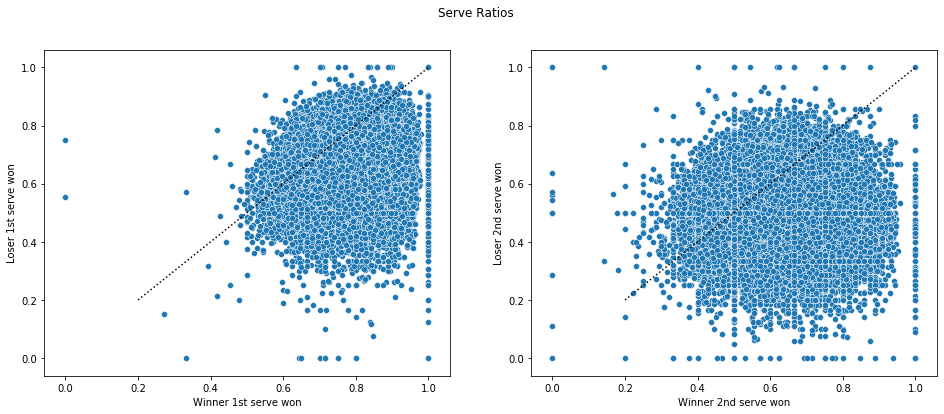

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Serve Ratios')

sns.scatterplot(ax=axes[0], x='w_1stRatio', y='l_1stRatio', data=data)
axes[0].set_xlabel('Winner 1st serve won')
axes[0].set_ylabel('Loser 1st serve won')

sns.scatterplot(ax=axes[1],x='w_2ndRatio', y='l_2ndRatio', data=data)
axes[1].set_xlabel('Winner 2nd serve won')
axes[1].set_ylabel('Loser 2nd serve won')

lims = [0.2, 1]
axes[0].plot( lims, lims, ':k')
axes[1].plot( lims, lims, ':k')
plt.show()

The percentage of first serve points won is clearly a strong predictor of the winner of a match; the winner won a higher percentage of first serve points in all matches below the line of equality, which is a large majority. Second serves show a similar but less extreme pattern, along with some stranger outliers. There seems to be at least one match where the winner won none of their second serve points and the loser won all of theirs, which is plausible but very surprising. It's possible that some of these extreme results represent errors, and it would be interesting to take a look at some of those matches more closely, but none of them represent an impossible result and the data as a whole look about like we'd expect.

In [17]:
print("Winner had higher 1st in pct: ", (data['w_1st%'] > data['l_1st%']).mean())
print("Winner won higher pct of 1st serve pts: ", (data['w_1stRatio'] > data['l_1stRatio']).mean())
print("Winner won higher pct of 2nd serve pts: ", (data['w_2ndRatio'] > data['l_2ndRatio']).mean())
print("Winner hit more total aces: ", (data['w_ace'] > data['l_ace']).mean())

Winner had higher 1st in pct:  0.5690415780932135
Winner won higher pct of 1st serve pts:  0.8319047292509543
Winner won higher pct of 2nd serve pts:  0.7748062812864294
Winner hit more total aces:  0.5969279297812522


Putting numbers to these and other significant serving stats, it turns out that 83% of the points in that first plot are below the line of equality, such that the winning player won a higher proportion of first serve points (it's too bad we can't use this data to predict winners). Interestingly, the winning player also had an advantage in percentage of first serves in and in total aces, but these numbers are much less predictive; tennis fans can probably think of plenty of example of matches where the winner hit more aces than the loser (one of Ivo Karlovic's then-record-setting matches was a Davis Cup rubber that he lost while hitting north of 50 aces, if I remember correctly; though that match isn't represented in this dataset). I'm more surprised, though, by the large gap between first-serve-in and first-serve-won percentages. I'd guess that there are a lot of lower-ranked players out there who rarely hit faults but whose serves are not big enough weapons to win many free points.

What about the breakdown of serving performance by surface?

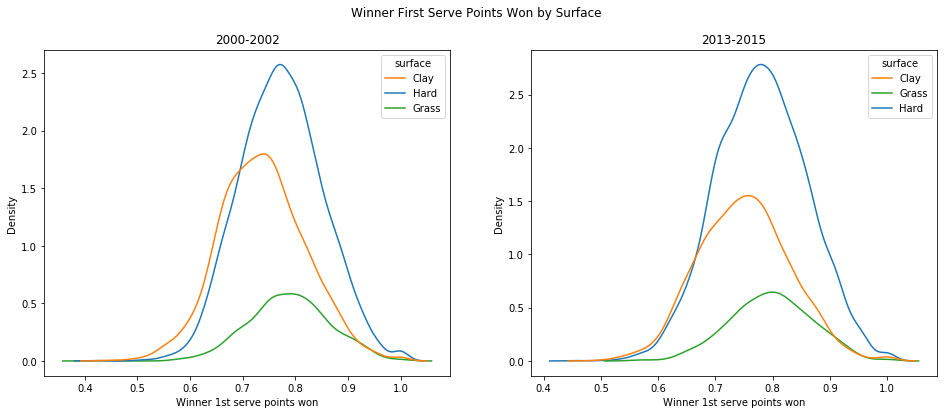

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Winner First Serve Points Won by Surface')
colors = {'Hard': 'C0', 'Clay': 'C1', 'Grass': 'C2', 'Carpet': 'C3'}

serving_old = data[(data['w_1stRatio'] > 0.4) 
                   & (data['date_parsed'] < '2003-01-01')
                   & (data['surface'] != 'Carpet')]
serving_new = data[(data['w_1stRatio'] > 0.4) 
                   & (data['date_parsed'] > '2013-01-01')]

sns.kdeplot(ax=axes[0], 
            data=serving_old, 
            x='w_1stRatio', 
            hue='surface', 
            multiple='layer',
            palette=colors) # , bins=70, stat='density',
axes[0].set_xlabel('Winner 1st serve points won')

axes[0].set_title('2000-2002')
sns.kdeplot(ax=axes[1], 
            data=serving_new, 
            x='w_1stRatio', 
            hue='surface', 
            multiple='layer',
            palette=colors)
axes[1].set_xlabel('Winner 1st serve points won')
axes[1].set_title('2013-2015')
plt.show()

Here, I've plotted the winner's first serve won percentage by surface in two time spans from the opposite ends of the dataset, which could give us a sense of whether serving performance changed over time (I've excluded matches played on indoor carpet, which only turn up in the earlier window and make up a tiny fraction of the total matches, making it harder to compare the two plots). In general, serve strength (or strength on serve, which is not necessarily the same thing) seems to have improved slightly on all surfaces.

We can juxtapose these two kinds of visualization to compare both players' strength on first serve on different surfaces, as in the plot below. This time, I've included carpet and used the whole dataset, and the results are not surprising: serve strength for both winner and loser improves as you move from slower to faster surfaces, with grass and carpet being about the same.

<Figure size 864x864 with 0 Axes>

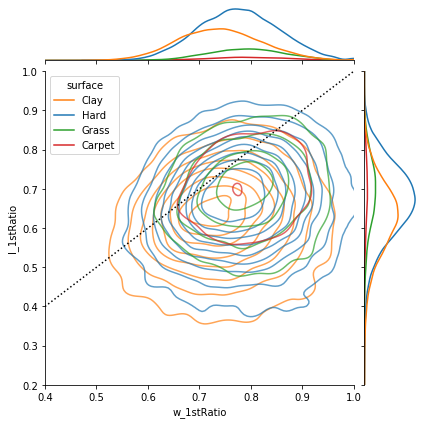

In [41]:
plt.figure(figsize=(12,12))

colors = {'Hard': 'C0', 'Clay': 'C1', 'Grass': 'C2', 'Carpet': 'C3'}
g = sns.jointplot(data=data, x='w_1stRatio', y='l_1stRatio', hue='surface', palette=colors, kind='kde', alpha=0.7)
lims = [0.4, 1]
g.ax_joint.plot(lims, lims, ':k')
g.ax_joint.set_xlim(0.4,1.0)
g.ax_joint.set_ylim(0.2,1.0)
plt.show()

As I've mentioned, there's much more that could be done, particularly around upsets (do more upsets happen in particular rounds? In matches involving lefties? Can we see evidence of hot streaks or bad game style matchups?). But for now, let's get a basic model running.

## Preparing for Training

The first step in preparing the data for modeling is to remove the leakage that comes from the winner-first order of the players. My strategy here is to make two copies of the data and swap the players in one copy, so that I end up with two versions of each match, with labels like `winner_rank` and `loser_rank` replaced with `p_rank` and `o_rank` (for "player" and "opponent"). A new `win` feature marks whether `p` or `o` wins.

Later on, we'll use each match's `unique_id` to randomly select one from each pair of duplicates, resulting in a more realistic dataset in which the "win" column is about half 1 and half 0. This whole scheme was just my own first pass at dealing with the issue, which I haven't seen discussed in the papers I've read; it's very possible that there's something fundamental I'm missing here, so I'd like to return to this issue and see if I can find discussion of it in other parts of the statistics/sports analytics world. My results so far seem to suggest that this approach worked, though.

In [10]:
# create a table that lists each match twice with W/L info for prediction purposes

p_cols = [
    'tourney_id', # Id of Tournament
    'tourney_name', # Name of the Tournament
    'surface', # Surface of the Court (Hard, Clay, Grass)
    'draw_size', # Number of people in the tournament
    'tourney_level', # Level of the tournament (A=ATP Tour, D=Davis Cup, G=Grand Slam, M=Masters)
    'tourney_date', # Start date of tournament
    'match_num', # Match number
    'p_id', # Id of winner
    'p_seed', # Seed of winner
    'p_entry', # How the winner entered the tournament
    'p_name', # Name of winner
    'p_hand', # Dominant hand of winner (L=Left, R=Right, U=Unknown?)
    'p_ht', # Height in cm of winner
    'p_ioc', # Country of winner
    'p_age', # Age of winner
    'p_rank', # Rank of winner
    'p_rank_points', # Rank points of winner
    'o_id',
    'o_seed',
    'o_entry',
    'o_name',
    'o_hand',
    'o_ht',
    'o_ioc',
    'o_age',
    'o_rank',
    'o_rank_points',
    'score', # Score
    'best_of', # Best of X number of sets
    'round', # Round
    'minutes', # Match length in minutes
    'p_ace', # Number of aces for winner
    'p_df', # Number of double faults for winner
    'p_svpt', # Number of service points played by winner 'w_2ndWon' / ('w_svpt' - 'w_1stIn' - 'w_df')
    'p_1stIn', # Number of first serves in for winner
    'p_1stWon', # Number of first serve points won for winner
    'p_2ndWon', # Number of second serve points won for winner
    'p_SvGms', # Number of service games played by winner
    'p_bpSaved', # Number of break points saved by winner
    'p_bpFaced', # Number of break points faced by winner
    'o_ace',
    'o_df',
    'o_svpt',
    'o_1stIn',
    'o_1stWon',
    'o_2ndWon',
    'o_SvGms',
    'o_bpSaved',
    'o_bpFaced', 
    #'is_gs', # a flag I was setting for grand slam matches; 'best_of' works just as well since the men play 5 sets
    'p_1st%', 
    'o_1st%', 
    'p_1stRatio', 
    'o_1stRatio',
    'p_2ndRatio', 
    'o_2ndRatio',
    'unique_id'
]

o_cols = []
for c in p_cols:
    if c[0:2] == 'p_':
        o_cols.append(c.replace('p_', 'o_'))
    elif c[0:2] == 'o_':
        o_cols.append(c.replace('o_', 'p_'))
    else:
        o_cols.append(c)

winner_data = data.drop('date_parsed', axis=1) 
winner_data.columns = p_cols
winner_data['win'] = True
winner_data['date_parsed'] = data['date_parsed']

loser_data = data.drop('date_parsed', axis=1)
loser_data.columns = o_cols
loser_data['win'] = False
loser_data['date_parsed'] = data['date_parsed']

# in this frame, you can find all of a single player's matches by grabbing df['p_*']
total_data = winner_data.append(loser_data)
total_data = total_data.drop('score', axis=1)
total_data = total_data.set_index('date_parsed').sort_index()

player_names = list(set(data['winner_name'].values).union(set(data['loser_name'])))

## Training

To train a model, we obviously can't use any data that isn't known prior to the match; instead, we need to collect various stats for each of the players in their previous matches. This requires one of those things you're not supposed to do in pandas – iteration. \*cue scary music\*. The basic idea is to go through each match in the dataset and, for each player, grab all of the matches from the past year. Iteration is essentially unavoidable when the data is structured as it is; there's no easy way around doing a new round of data processing for each match in the dataset, since we need to select only the matches featuring the current players each time. (Though a different initial organization could make things faster, as I discuss briefly below)

The actual period over which to collect data is an important question, since it depends on your theory of how to predict upsets. Is very recent performance most important? The past six months? year? The models I've seen tend to use a year's worth of data, and to be honest I haven't seen a lot of difference between timespans ranging from six months to a year, but I consider it an open question. An even better version of the question would probably be whether to take a longer interval but weigh more recent matches more heavily, something I haven't tried but will consider in the future.

The training process currently takes about 3 hours for sixteen years of matches. I begin training at the start of 2001, since each training datapoint requires a year's worth of matches. The worst inefficiency aside from the iteration itself is the fact that I'm really computing everything twice, for the two permutations of each match. I don't think it would be terribly hard to fix this, but it would make the code a little less intuitive, and so far it hasn't been an inconvenience to wait it out. Probably the best way to improve efficiency would be to reorganize the data significantly, making a separate table for each player and then generating the actual training data by merging it all back together on the basis of the match IDs. Another improvement for the next iteration.

Most of the specific features that I generate in this step are intuitive, but there are a couple that are very experimental, where I've tried to produce metrics for each player's upset-ibility (or ability to hold to their rank) and ability to produce upsets. This involves taking the average of the player's rank divided by the opponent's rank for all of the times they succumbed to/produced an upset. It's a work in progress, designed in particular to capture how upset-prone players are; it's far from perfect, since, for example, a player who is ranked \#1 for a long period will only ever be upset, though in principle their upsettee factor shouldn't be too bad if they manage to beat lower ranked players and lose mainly to, say, top-10 players. But I plan to experiment with this further, since it seems to me that there must be some way to do some more advanced feature engineering to better capture some basic intuitions about upsets.

In [3004]:
# add: aces per match (trying to capture more about serve strength)

training_data = total_data[str(training_year + 1) + '-01-01':][['unique_id',
                                           'round',
                                           'best_of',
                                           'surface',
                                           'p_name',
                                           'p_ht',
                                           'p_rank',
                                           'p_hand',
                                           'o_name',
                                           'o_ht',
                                           'o_rank',
                                           'o_hand',
                                           'win']].copy()
training_data['date_time'] = training_data.index
training_data.index = range(len(training_data))
training_timestamps = training_data[['date_time',
                                     'p_name',
                                     'o_name',
                                     'best_of',
                                     'surface',
                                     'round',
                                     'p_hand',
                                     'o_hand']].copy()

total_matches = len(training_timestamps)
how_many = total_matches

for match in tqdm(training_timestamps.iloc[:how_many].itertuples(), total=how_many):
    timestamp = match.date_time
    prevMatch = timestamp - datetime.timedelta(0,1)
    yearAgo = prevMatch - datetime.timedelta(120)
    
    p_matches = total_data[total_data['p_name'].str.contains(match.p_name)]
    p_matches = p_matches[yearAgo:prevMatch]
    
    o_matches = total_data[total_data['p_name'].str.contains(match.o_name)]
    o_matches = o_matches[yearAgo:prevMatch]
    
    bestof = match.best_of
    this_round = match.round
    this_surface = match.surface
    this_p_hand = match.p_hand
    this_o_hand = match.o_hand
    this_p_name = match.p_name
    this_o_name = match.o_name
        
    ### P stats
    if len(p_matches) >= 1:
        p_rank_change = p_matches.iloc[0].p_rank - p_matches.iloc[-1].p_rank
        
        p_record = p_matches['win'].mean()
        
        p_matches_played = len(p_matches)
        
        if this_o_name in p_matches['o_name'].to_numpy():
            p_H2H = p_matches[p_matches.o_name == this_o_name].win.mean()
        else:
            p_H2H = 0.5
        
        if this_o_hand in p_matches['o_hand'].to_numpy():
            p_win_o_hand = p_matches[p_matches.o_hand == this_o_hand].win.mean()
        else:
            p_win_o_hand = 0
        
        if bestof in p_matches['best_of'].to_numpy():
            p_win_bestof = p_matches[p_matches.best_of == bestof].win.mean()
        else:
            p_win_bestof = 0
        
        if this_round in p_matches['round'].to_numpy():
            p_win_round = p_matches[p_matches['round'] == this_round].win.mean()
        else:
            p_win_round = 0
        
        if this_surface in p_matches['surface'].to_numpy():
            p_win_surface = p_matches[p_matches.surface == this_surface].win.mean()
        else:
            p_win_surface = 0
        
        if p_matches['p_df'].sum() > 0:
            p_ace_to_df = p_matches['p_ace'].sum() / p_matches['p_df'].sum()
        else:
            p_ace_to_df = None
        
        # One problem is low-ranked players who have a number of matches (incl wins) but have never
        # beaten someone ranked lower than them
        p_upperdog = p_matches[p_matches.p_rank < p_matches.o_rank]
        if len(p_upperdog) >= 1:
            p_upperdog_wl = p_upperdog.win.mean()

            p_favored_losses = p_upperdog[p_upperdog.win == False]
            p_f_upset_weight = p_favored_losses['o_rank'] / p_favored_losses['p_rank']
            p_upsettee_factor = -1 * p_f_upset_weight.mean()
        else:
            p_upperdog_wl = None
            p_upsettee_factor = None 
        
        # this still matters because someone could be ranked no 1 for a  whole year and never be underdog
        p_underdog = p_matches[p_matches.p_rank > p_matches.o_rank]
        if len(p_underdog) >= 1:
            p_underdog_wl = p_underdog.win.mean()

            p_underdog_wins = p_underdog[p_underdog.win]
            p_u_upset_weight = p_underdog_wins['p_rank'] / p_underdog_wins['o_rank']
            p_upset_factor = p_u_upset_weight.mean()
        else:
            p_underdog_wl = None 
            p_upset_factor = None

        # Aggregating the standard stats

        p_bpFacedPerSet = p_matches.p_bpFaced.sum() / p_matches.best_of.sum() # see below for alternative approx
        #bpFacedPerSet = sum(t_matches.p_bpFaced / t_matches.best_of) / len(t_matches)

        p_bpSavedPerSet = p_matches.p_bpSaved.sum() / p_matches.best_of.sum()

        p_first_in_pct = p_matches['p_1st%'].mean()
        p_first_won = p_matches['p_1stRatio'].mean()
        p_second_won = p_matches['p_2ndRatio'].mean()
    else:
        # Need to go back and postprocess to fill these with appropriate values
        p_rank_change = 0 # don't fill
        p_record = 0
        p_matches_played = 0
        p_upperdog_wl = None # fill with median
        p_underdog_wl = None # fill with median
        p_upset_factor = None # fill with min
        p_upsettee_factor = None # fill with max?
        p_bpFacedPerSet = None
        p_bpSavedPerSet = None
        p_first_in_pct = None
        p_first_won = None
        p_second_won = None
        p_ace_to_df = None
    
    training_data.loc[match.Index, 'p_record'] = p_record
    training_data.loc[match.Index, 'p_matches_played'] = p_matches_played
    training_data.loc[match.Index, 'p_rank_change'] = p_rank_change
    training_data.loc[match.Index, 'p_H2H'] = p_H2H
    training_data.loc[match.Index, 'p_win_o_hand'] = p_win_o_hand
    training_data.loc[match.Index, 'p_win_bestof'] = p_win_bestof
    training_data.loc[match.Index, 'p_win_round'] = p_win_round
    training_data.loc[match.Index, 'p_win_surface'] = p_win_surface
    training_data.loc[match.Index, 'p_upperdog_wl'] = p_upperdog_wl
    training_data.loc[match.Index, 'p_underdog_wl'] = p_underdog_wl
    training_data.loc[match.Index, 'p_upset_factor'] = p_upset_factor
    training_data.loc[match.Index, 'p_upsettee_factor'] = p_upsettee_factor
    training_data.loc[match.Index, 'p_bpFacedPerSet'] = p_bpFacedPerSet
    training_data.loc[match.Index, 'p_bpSavedPerSet'] = p_bpSavedPerSet
    training_data.loc[match.Index, 'p_first_in_pct'] = p_first_in_pct
    training_data.loc[match.Index, 'p_first_won'] = p_first_won
    training_data.loc[match.Index, 'p_second_won'] = p_second_won
    training_data.loc[match.Index, 'p_ace_to_df'] = p_ace_to_df
    
    
    ### O stats
    if len(o_matches) >= 1:
        o_rank_change = o_matches.iloc[0].p_rank - o_matches.iloc[-1].p_rank
        
        o_record = o_matches['win'].mean()
        
        o_matches_played = len(o_matches)
        
        if this_p_name in o_matches['o_name'].to_numpy():
            o_H2H = o_matches[o_matches.o_name == this_p_name].win.mean()
        else:
            o_H2H = 0.5
        
        if this_p_hand in o_matches['o_hand'].to_numpy():
            o_win_p_hand = o_matches[o_matches.o_hand == this_p_hand].win.mean()
        else:
            o_win_p_hand = 0.5
        
        if bestof in o_matches['best_of'].to_numpy():
            o_win_bestof = o_matches[o_matches.best_of == bestof].win.mean()
        else:
            o_win_bestof = 0
        
        if this_round in o_matches['round'].to_numpy():
            o_win_round = o_matches[o_matches['round'] == this_round].win.mean()
        else:
            o_win_round = 0
        
        if this_surface in o_matches['surface'].to_numpy():
            o_win_surface = o_matches[o_matches.surface == this_surface].win.mean()
        else:
            o_win_surface = 0
        
        if o_matches['p_df'].sum() > 0:
            o_ace_to_df = o_matches['p_ace'].sum() / o_matches['p_df'].sum()
        else:
            o_ace_to_df = None

        o_upperdog = o_matches[o_matches.p_rank < o_matches.o_rank]
        if len(o_upperdog) >= 1:
            o_upperdog_wl = o_upperdog.win.mean()

            o_favored_losses = o_upperdog[o_upperdog.win == False]
            o_f_upset_weight = o_favored_losses['o_rank'] / o_favored_losses['p_rank']
            o_upsettee_factor = -1 * o_f_upset_weight.mean()
        else:
            o_upperdog_wl = None 
            o_upsettee_factor = None # this is technically a high number...

        o_underdog = o_matches[o_matches.p_rank > o_matches.o_rank]
        if len(o_underdog) >= 1:
            o_underdog_wl = o_underdog.win.mean()

            # need to do some fixing of these
            o_underdog_wins = o_underdog[o_underdog.win]
            o_u_upset_weight = o_underdog_wins['p_rank'] / o_underdog_wins['o_rank']
            o_upset_factor = o_u_upset_weight.mean()
        else:
            o_underdog_wl = None
            o_upset_factor = None

        # Aggregating the standard stats

        o_bpFacedPerSet = o_matches.p_bpFaced.sum() / o_matches.best_of.sum() # see below for alternative approx
        #bpFacedPerSet = sum(t_matches.p_bpFaced / t_matches.best_of) / len(t_matches)

        o_bpSavedPerSet = o_matches.p_bpSaved.sum() / o_matches.best_of.sum()

        o_first_in_pct = o_matches['p_1st%'].mean()
        o_first_won = o_matches['p_1stRatio'].mean()
        o_second_won = o_matches['p_2ndRatio'].mean()
    else:
        # Need to go back and postprocess to fill these with appropriate values
        o_rank_change = 0 # don't fill
        o_record = 0
        o_matches_played = 0
        o_upperdog_wl = None # fill with median
        o_underdog_wl = None # fill with median
        o_upset_factor = None # fill with min
        o_upsettee_factor = None # fill with max?
        o_bpFacedPerSet = None
        o_bpSavedPerSet = None
        o_first_in_pct = None
        o_first_won = None
        o_second_won = None
        o_ace_to_df = None
    
    training_data.loc[match.Index, 'o_record'] = o_record
    training_data.loc[match.Index, 'o_matches_played'] = o_matches_played
    training_data.loc[match.Index, 'o_rank_change'] = o_rank_change
    training_data.loc[match.Index, 'o_H2H'] = o_H2H
    training_data.loc[match.Index, 'o_win_p_hand'] = o_win_p_hand
    training_data.loc[match.Index, 'o_win_bestof'] = o_win_bestof
    training_data.loc[match.Index, 'o_win_round'] = o_win_round
    training_data.loc[match.Index, 'o_win_surface'] = o_win_surface
    training_data.loc[match.Index, 'o_upperdog_wl'] = o_upperdog_wl
    training_data.loc[match.Index, 'o_underdog_wl'] = o_underdog_wl
    training_data.loc[match.Index, 'o_upset_factor'] = o_upset_factor
    training_data.loc[match.Index, 'o_upsettee_factor'] = o_upsettee_factor
    training_data.loc[match.Index, 'o_bpFacedPerSet'] = o_bpFacedPerSet
    training_data.loc[match.Index, 'o_bpSavedPerSet'] = o_bpSavedPerSet
    training_data.loc[match.Index, 'o_first_in_pct'] = o_first_in_pct
    training_data.loc[match.Index, 'o_first_won'] = o_first_won
    training_data.loc[match.Index, 'o_second_won'] = o_second_won
    training_data.loc[match.Index, 'o_ace_to_df'] = o_ace_to_df

    
# Fill NaN values for players who hadn't yet played a match or have never upset/been upset

training_data.p_upperdog_wl.fillna(training_data.p_upperdog_wl.min(), inplace=True) # fill with median
training_data.p_underdog_wl.fillna(training_data.p_underdog_wl.min(), inplace=True) # fill with median
training_data.p_upset_factor.fillna(training_data.p_upset_factor.min(), inplace=True) # fill with min
training_data.p_upsettee_factor.fillna(training_data.p_upsettee_factor.min(), inplace=True) # fill with max?
training_data.p_bpFacedPerSet.fillna(training_data.p_bpFacedPerSet.median(), inplace=True) # median
training_data.p_bpSavedPerSet.fillna(training_data.p_bpSavedPerSet.median(), inplace=True) # median
training_data.p_first_in_pct.fillna(training_data.p_first_in_pct.median(), inplace=True) # median
training_data.p_first_won.fillna(training_data.p_first_won.median(), inplace=True) # median
training_data.p_second_won.fillna(training_data.p_second_won.median(), inplace=True) # median
training_data.p_ace_to_df.fillna(training_data.p_ace_to_df.median(), inplace=True) # median

training_data.o_upperdog_wl.fillna(training_data.o_upperdog_wl.min(), inplace=True) # fill with median
training_data.o_underdog_wl.fillna(training_data.o_underdog_wl.min(), inplace=True) # fill with median
training_data.o_upset_factor.fillna(training_data.o_upset_factor.min(), inplace=True) # fill with min
training_data.o_upsettee_factor.fillna(training_data.o_upsettee_factor.min(), inplace=True) # fill with max?
training_data.o_bpFacedPerSet.fillna(training_data.o_bpFacedPerSet.median(), inplace=True) # median
training_data.o_bpSavedPerSet.fillna(training_data.o_bpSavedPerSet.median(), inplace=True) # median
training_data.o_first_in_pct.fillna(training_data.o_first_in_pct.median(), inplace=True) # median
training_data.o_first_won.fillna(training_data.o_first_won.median(), inplace=True) # median
training_data.o_second_won.fillna(training_data.o_second_won.median(), inplace=True) # median
training_data.o_ace_to_df.fillna(training_data.o_ace_to_df.median(), inplace=True) # median

DOBs = atp_players[['full_name', 'DOB']].set_index('full_name', drop=True)
training_data = training_data.join(DOBs, on='p_name', how='left')
training_data.rename(columns={'DOB':'p_DOB'}, inplace=True)
training_data = training_data.join(DOBs, on='o_name', how='left')
training_data.rename(columns={'DOB':'o_DOB'}, inplace=True)
training_data['p_age'] = (training_data.date_time - training_data.p_DOB).dt.days / 365.25
training_data['o_age'] = (training_data.date_time - training_data.o_DOB).dt.days / 365.25
training_data.drop(columns=['p_DOB','o_DOB'], inplace=True)
training_data = training_data.loc[testDf['p_age'].notna() & training_data['o_age'].notna()]

# Save the resulting data
training_data.to_csv("./atp_data/atp_training_2000-2015_exp_365.csv")

In [89]:
# This is just here so we can load saved data without running the training loop
training_data = pd.read_csv("./atp_data/atp_training_2000-2015_exp_120.csv")

## Preprocessing and more feature engineering

From the full training set, we need to filter out half of the matches, randomly choosing between the permutation where `p` wins and the one where `o` wins.

In [90]:
training_data_filtered = training_data.sort_values(['date_time','unique_id']).reset_index().drop(columns=['index'])

# [0347]
iloc_index = []
for i in range(int(len(training_data) / 2)):
    iloc_index.append(2 * i + np.random.randint(0,2))

training_data_filtered = training_data_filtered.iloc[iloc_index,:]
len(training_data_filtered)

40940

In [91]:
# This is just a way to grab subsets of the training data if we want to try training on smaller date ranges
training_slice = training_data_filtered#[(training_data_filtered.date_time > '2008-01-01') & (training_data_filtered.date_time < '2014-01-01')]

There are a couple steps involved in preprocessing the data. We drop unhelpful information like name, date, and some of the categorical variables like handedness and surface. These latter two are incorporated into the model via features that capture each player's record on the current surface, or against lefties/righties, which should capture more information than the raw categorical value (I've left the categorical encoder intact in the code in case I want to experiment with reviving these features). Features like `best_of` and `round` are also captured via ratios capturing a player's performance in matches corresponding to the various categories, though at present this means the clever encoding for the number of rounds remaining is going unused.

Most of the rest of the features are present for both `p` and `o`, and rather than simply toss both values into the model, I opted to turn them into ratios, in order to give the model a measure of the relation between the two players' strength in each category. Some features occasionally take zero as a value (as when a player hasn't played a match on a given surface in the past year), so I've used ratios of (1 + p) / (1 + n); this is an aspect of feature engineering that I'm still learning about and experimenting with, as there may be a better practice or a different way to encode these features that I don't know about. But later testing seems to show that these modified ratios do provide the model with a lot of useful information.

You can see that I've left out a few features, which is a result of some experimentation with which combinations give the best results, though there may be more improvements to be made just in terms of selecting among the current features. The other important thing in this block of code is the scaler, which makes the data friendlier for certain modeling methods and allows for easier comparisons.

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

categorical_transformer = LabelEncoder()

def preprocess_df(df):
    
    X = df.drop(columns=['p_name',
                                             'o_name',
                                             'date_time',
                                             'p_hand',
                                             'o_hand',
                                             'surface',
                                             'best_of',
                                             'round',
                                             'Unnamed: 0', # this is only for when loading from csv
                                             'o_H2H',
                                             'unique_id'])



    upset_Xp = (X['p_rank'] > X['o_rank']) & (X['win'] == 1)
    upset_Xo = (X['o_rank'] > X['p_rank']) & (X['win'] == 0)
    # This is mostly so that 'upset' be used as a target, which in reality gives poor performance
    X['upset'] = upset_Xp | upset_Xo

    y = X['win']
    #y = X['upset']

    X = X.drop(columns=['win', 'upset'])

    # age diff seems to work better than just including age
    X['age_ratio'] = X['p_age'] / X['o_age']
    X = X.drop(columns=['p_age','o_age'])

    # Height ratio - need to train on this first
    X['ht_ratio'] = X['p_ht'] / X['o_ht']
    X = X.drop(columns=['p_ht','o_ht'])

    # rank differential seems more informative!
    X['rank_ratio'] = (X['p_rank'] + 1) / (X['o_rank'] + 1)
    #X['rank_diff'] = X['p_rank']- X['o_rank']
    X = X.drop(columns=['p_rank','o_rank'])

    # A ratio or difference of rank changes doesn't tell us much, so I don't compute it and leave in the originals
    #X = X.drop(columns=['p_rank_change','o_rank_change'])

    X['first_in_ratio'] = X['p_first_in_pct'] / X['o_first_in_pct']
    X = X.drop(columns=['p_first_in_pct','o_first_in_pct'])

    X['surface_ratio'] = np.log((X['p_win_surface'] + 1) / (X['o_win_surface'] + 1))
    X = X.drop(columns=['p_win_surface','o_win_surface'])

    X['firstW_ratio'] = X['p_first_won'] / (X['o_first_won'])
    X = X.drop(columns=['p_first_won','o_first_won'])

    X['secondW_ratio'] = X['p_second_won'] / (X['o_second_won'])
    X = X.drop(columns=['p_second_won','o_second_won'])

    X['bpFaced_ratio'] = (X['p_bpFacedPerSet'] + 1) / (X['o_bpFacedPerSet'] + 1)
    X = X.drop(columns=['p_bpFacedPerSet','o_bpFacedPerSet'])

    X['bpSaved_ratio'] = (X['p_bpSavedPerSet'] + 1) / (X['o_bpSavedPerSet'] + 1)
    X = X.drop(columns=['p_bpSavedPerSet','o_bpSavedPerSet'])

    #X['favored_ratio'] = np.log((X['p_upperdog_wl'] + 1) / (X['o_upperdog_wl'] + 1))
    X = X.drop(columns=['p_upperdog_wl','o_upperdog_wl'])

    #X['underdog_ratio'] = np.log((X['p_underdog_wl'] + 1) / (X['o_underdog_wl'] + 1))
    X = X.drop(columns=['p_underdog_wl','o_underdog_wl'])

    X['upset_ratio'] = X['p_upset_factor'] / (X['o_upset_factor'])
    X = X.drop(columns=['p_upset_factor','o_upset_factor'])

    #X['upsettee_ratio'] = np.log((X['p_upsettee_factor'] + 1) / (X['o_upsettee_factor'] + 1))
    X = X.drop(columns=['p_upsettee_factor','o_upsettee_factor'])

    X['matches_ratio'] = (X['p_matches_played'] + 1) / (X['o_matches_played'] + 1)
    X = X.drop(columns=['p_matches_played','o_matches_played'])

    # including record makes it a little harder to catch upsets but is good for accuracy
    #X['record_ratio'] = (X['p_record'] + 1) / (X['o_record'] + 1)
    X = X.drop(columns=['p_record','o_record'])

    X['hand_ratio'] = (X['p_win_o_hand'] + 1) / (X['o_win_p_hand'] + 1)
    X = X.drop(columns=['p_win_o_hand','o_win_p_hand'])

    X['round_ratio'] = (X['p_win_round'] + 1) / (X['o_win_round'] + 1)
    X = X.drop(columns=['p_win_round','o_win_round'])

    X['bestof_ratio'] = (X['p_win_bestof'] + 1) / (X['o_win_bestof'] + 1)
    X = X.drop(columns=['p_win_bestof','o_win_bestof'])

    X['ace_df_ratio'] = (X['p_ace_to_df'] + 1) / (X['o_ace_to_df'] + 1)
    X = X.drop(columns=['p_ace_to_df','o_ace_to_df'])

    #X['p_hand_cat'] = categorical_transformer.fit_transform(training_data_filtered['p_hand'])
    #X['o_hand_cat'] = categorical_transformer.transform(training_data_filtered['o_hand'])
    #X['surface_cat'] = categorical_transformer.fit_transform(training_data_filtered['surface'])
    #X['p_win_bestof'].fillna(0, inplace=True)
    #X['o_win_bestof'].fillna(0, inplace=True)
    return X, y

X, y = preprocess_df(training_slice)

scaler = StandardScaler()
X_t = scaler.fit_transform(X)

A little interlude here: some of these features are pretty heavily correlated, and it's worth looking into how much they overlap in case we can remove features that are too closely tied to others to tell us anything new. Obviously things like first serve percentage and break points faced will tend to be correlated, as will things like record by surface and overall record; it's still possible for features that are somewhat correlated to provide useful information, especially in predicting upsets, so this is a tricky issue and we don't want to pull too many features that might still provide useful information. The heatmap below shows correlations among all the features, and the dendrogram clusters them hierarchically. One way of selecting features is to 'chop' the dendrogram at a particular level, and the set of features included here is one that I arrived at after a few rounds of chopping and swapping  (and is still a work in progress).

The version of the diagram that comes out post-feature engineering shows fewer strong intercorrelations than in the unmodified dataset, but I've included it so you can get the basic idea.

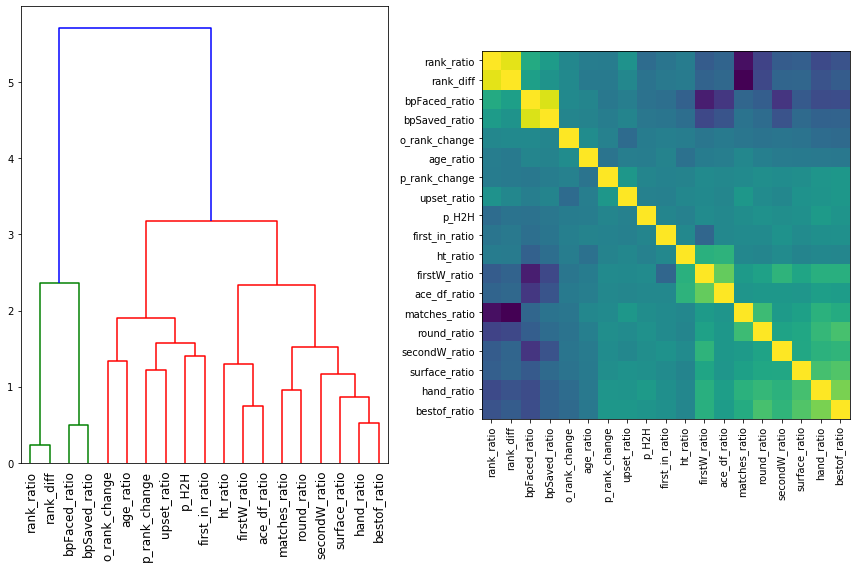

In [58]:
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_t).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=X.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

### The model

We'll keep things simple for now and just try out a couple of basic models: logistic regression and a random forest classifier. While I've experimented a bit with tuning the hyperparameters, I'm not systematically optimizing them for the moment; I'm most interested for now in the general shape of the results. Logistic regression is perhaps the classic model for binary classification, and random forests are one of the best-performing all-around classifiers, so they'll make for a good starting point.

I'm using 8-fold cross validation here and simply measuring predictive accuracy, but in the next post I'll look more closely at each model's confidence scores.

In [116]:
'''rf_model = GradientBoostingClassifier(learning_rate=0.05,
                                   n_estimators=1000,
                                   #validation_fraction=0.1,
                                   #n_iter_no_change=3,
                                   random_state=0,
                                  )'''


log_model = LogisticRegression(max_iter=100, 
                           penalty='l2',
                           #l1_ratio=0.9,
                           #tol=0.0001,
                           C=1,
                           solver='lbfgs')


rf_model = RandomForestClassifier(n_estimators=100, 
                               max_depth=None, # this is best
                               min_samples_split=2, # this seems to be best
                               min_samples_leaf=3, # this seems to be best
                               max_features=None, 
                               max_leaf_nodes=100)

# cross-val
log_score = cross_val_score(log_model, X_t, y, cv=8)
rf_score = cross_val_score(rf_model, X_t, y, cv=8)

Logistic Regression Accuracy: 0.6580618022448217
Random Forest Accuracy: 0.6649989741800371


Before we peek at the scores themselves, let's take a look at how the models treat the various features. Because the training data has all been scaled, the coefficients for the logistic regression are relatively easy to interpret – the coefficients all measure the effect on the final prediction of proportional changes in the respective features.

In [110]:
log_coefs = pd.DataFrame(data={'coef': log_model.coef_[0], 'feature':X.columns})
log_coefs.sort_values('coef')

,coef,feature
5,-1.124801,rank_ratio
3,-0.080605,age_ratio
16,-0.055673,bestof_ratio
11,-0.051398,bpSaved_ratio
10,-0.039235,bpFaced_ratio
0,-0.021280,p_rank_change
12,-0.021194,upset_ratio
4,-0.004026,ht_ratio
2,0.014083,o_rank_change
6,0.052598,first_in_ratio


By far most notable is the effect of `rank_ratio`, which tends to swing very heavily for a proportionally smaller change in rankings. The scale of this coefficient will vary depending on how the ranks are being compared; taking the proportion between the two rankings will result in a different spread of values than taking their difference. The coefficient itself is negative precisely because better rankings are smaller numbers, so a very small `rank_ratio` means `p` has a much better ranking than `o`, which means that a decrease in `rank_ratio` means a higher probability of `p` winning, which corresponds to a value of `1` in the target feature, `win`.

We could think through all of the features in this way, but most interesting for now is to see roughly where different features fall in the list. It's fairly obvious why the model would get a lot of information out of ranking, since we know we can get ~65\% of matches right merely by guessing according to that one feature. Age, number of matches played, and surface strength follow ranking in importance, themselves followed by most of the major serve stats. Head-to-head, rank change, height, and my experimental upset factor are among the weakest predictors; I'm not surprised my upset factor didn't work too well, but I am surprised to see head-to-head playing such a small role. These kinds of issues can sometimes result from collinearity, though H2H has relatively weak correlations with other features in the heatmap above. I'll return to these results and think through them further in future posts, as I continue to develop the models.

Now for the random forest. We can't compare these values directly to the logistic regression coefficients because they're not measuring the same thing; partly because they're aggregated from the many individual predictors, the random forest feature importance values don't relate quite as straightforwardly to the model's output, and we can get a basic intuitive sense of this from the fact that none of them have negative values, which means they aren't just pushing the resulting classification towards `1` or `0` as in the logistic regression. Nonetheless, we can still get a sense of how the model is handling different features based on the relative differences in the importance values.

In [115]:
rf_feats = pd.DataFrame(data={'importance': rf_model.feature_importances_, 'feature':X.columns})
rf_feats.sort_values('importance')

,importance,feature
1,0.001076,p_H2H
15,0.007635,round_ratio
4,0.009847,ht_ratio
6,0.012485,first_in_ratio
16,0.012735,bestof_ratio
11,0.013620,bpSaved_ratio
17,0.014747,ace_df_ratio
2,0.014897,o_rank_change
0,0.016405,p_rank_change
12,0.017786,upset_ratio


Once again, H2H comes in at the bottom and `rank_ratio` is most important (and by a massive margin). Rank change seems to be slightly more important here than for the logistic regression, while performance by round goes from being one of the most important features to one of the least important. It's also interesting that the two models swap the order of importance for break points faced and break points saved. These differences will all be worth exploring in the future.

Finally, to compare more closely with the bookmakers' results, we need to know how the models perform on upsets, not just the generic accuracy across all matches. To that end, I refit both models on a single training-validation split – this gives a slightly incomplete picture since the random split will give less consistent results than we'd get from cross-validation, but it gets us in the ballpark and gives us easier access to the specific feature and target values, which we need in order to do some additional analysis. As before, we'll compute specificity (what proportion of the non-upsets did we get right?), sensitivity (what proportion of the upsets did we get right?), negative predictive value (how often were we right when we guessed that a match was not an upset?), and precision (how often were we right when we guessed that a match was an upset?).

In [117]:
# Do one sample train-test split for testing upset results
X_train, X_valid, y_train, y_valid = train_test_split(X_t, y, train_size=0.8, test_size=0.2) # random_state

log_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

def upset_stats(X_valid, y_valid, X_columns, model):

    X_v_df = pd.DataFrame(scaler.inverse_transform(X_valid), columns=X_columns)
    X_v_df['win'] = pd.Series(y_valid.values)

    probs = model.predict_proba(X_valid)
    predicts = model.predict(X_valid)
    actual = y_valid.values
    correct = predicts == actual

    X_v_df['predicted'] = pd.Series(predicts)

    '''upset_1 = (X_v_df['rank_diff'] > 0) & (X_v_df['win'] == 1)
    upset_2 = (X_v_df['rank_diff'] < 0) & (X_v_df['win'] == 0)
    upset = upset_1 | upset_2'''
    
    upset_1 = (X_v_df['rank_ratio'] > 1) & (X_v_df['win'] == 1)
    upset_2 = (X_v_df['rank_ratio'] < 1) & (X_v_df['win'] == 0)
    upset = upset_1 | upset_2

    predicted_upset_cor = upset & correct

    '''pred_upset_1 = (X_v_df['rank_diff'] > 0) & (X_v_df['predicted'] == 1)
    pred_upset_2 = (X_v_df['rank_diff'] < 0) & (X_v_df['predicted'] == 0)
    pred_upset = pred_upset_1 | pred_upset_2'''
    
    pred_upset_1 = (X_v_df['rank_ratio'] > 1) & (X_v_df['predicted'] == 1)
    pred_upset_2 = (X_v_df['rank_ratio'] < 1) & (X_v_df['predicted'] == 0)
    pred_upset = pred_upset_1 | pred_upset_2
    
    print('specificity and neg pred value: ',
        (~upset & ~pred_upset).sum() / (~upset).sum(), 
          (~upset & ~pred_upset).sum() / (~pred_upset).sum()
    )
    
    print('sensitivity and precision: ', 
          predicted_upset_cor.sum() / upset.sum(), 
          predicted_upset_cor.sum() / pred_upset.sum()
         )

print("Logistic model")
print('Accuracy:', np.mean(log_score))
upset_stats(X_valid, y_valid, X.columns, log_model)
print("\nRandom Forest model")
print('Accuracy:', np.mean(rf_score))
upset_stats(X_valid, y_valid, X.columns, rf_model)

Logistic model
Accuracy: 0.6580618022448217
specificity and neg pred value:  0.8527946873270614 0.7027972027972028
sensitivity and precision:  0.29345861944344054 0.5043478260869565

Random Forest model
Accuracy: 0.6649989741800371
specificity and neg pred value:  0.9324847814056447 0.6854237288135593
sensitivity and precision:  0.16154680159016985 0.5498154981549815


In [87]:
print("BCM (odds) model (2010–2015)")
print("Accuracy:", odds_matches['pred_match_correctly'].mean())
print('specificity and neg pred value: ', odds_spec, odds_npv)
print('sensitivity and precision: ', odds_sens, odds_prec)

BCM (odds) model (2010–2015)
Accuracy: 0.7104411169566976
specificity and neg pred value:  0.8934327155519742 0.7331790378574972
sensitivity and precision:  0.34095549203756637 0.6121700879765396


The most accurate of my models, the random forest, comes in around 4.5\% behind the BCM, with the logistic regression trailing that by another 0.6\%. The random forest has the best specificity, correctly calling 93\% of the non-upsets, over the BCM's roughly 89\% and the logistic regression's 87\%, but the random forest gets that performance at the cost of a worse hit rate, being comparatively too eager to predict non-upsets (this is perhaps not surprising given the huge weight the random forest places on ranking).

The random forest also did quite poorly at picking upsets, only getting about 16\% of them, compared to a very respectable 29\% for the logistic regression and more impressive 34% for the BCM. The random forest was more likely than the logistic regression to be correct when it did pick an upset (56\% to 51\%), but this is partly just because it did so less often.

The BCM clearly wins out here (though it's important to keep in mind that it only represents a subset of the matches included in my models, so it's only to be understood as a rough baseline). I'm not unhappy with the performance of these basic models,given that there seems to be a lot of room for more feature engineering. I won't be retiring early (or going to work for the bookmakers) just yet, but I'm excited to explore some of the avenues mentioned throughout this post, and particularly to take a closer look at the confidence values offered by the models in relation to the feature importances. It will also be interesting to test an even simpler decision tree model, which will allow for easy visualization and the development of some intuitions about how the data is leading to particular decisions. It would also be worth tracking some of the models' statistics over time to see if there are any seasonal patterns; do predictions get better or worse at grand slams, either for upsets or for all matches? How does the specific ranking of either player affect the prediction? The published literature offers some limited insight into these kinds of questions, but there's much more that could be done. It will also be interesting to look closely at some specific matches to see where the models are going wrong (or right) for particular kinds of matchups.

**To be continued . . .**